Here we learn about stacking models and getting a better model

In [85]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
import gc

In [53]:
# Load in the train and test datasets
train = pd.read_csv('input/train_processed.csv',index_col=0)
test = pd.read_csv('input/test_processed.csv',index_col=0)
# Store our passenger ID for easy access
train.head(3)
train.info()
gc.collect()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null int64
Parch          891 non-null int64
Fare           891 non-null int64
Embarked       891 non-null int64
Name_length    891 non-null int64
Has_Cabin      891 non-null int64
FamilySize     891 non-null int64
IsAlone        891 non-null int64
Title          891 non-null int64
dtypes: int64(12)
memory usage: 90.5 KB


6946

<Figure size 1008x864 with 0 Axes>

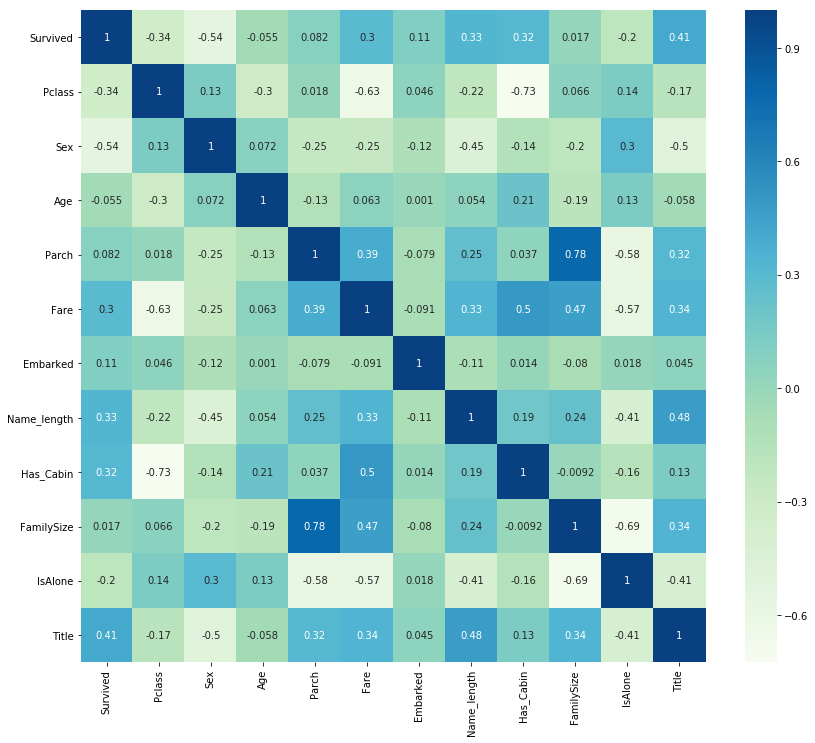

In [38]:
#heatmap
plt.figure(figsize=(14,12))
sns.heatmap(train.corr(),cmap=plt.cm.GnBu,annot=True)

This tells us that only IsAlone and Parch are correlated. Hence, no redundant information

In [39]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

In [42]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [56]:
# note: x_test is predicted for each fold, and stored in pred_test_skf
#the average of the predictions is stored in pred_test
def get_predictions(classifier, x_train,y_train,x_test ):
    for i,(train_index,val_index) in enumerate(kf):
        pred_val = np.zeros((ntrain,)) # stores the predicions for all validationsets
        pred_test = np.zeros((ntest,)) #stores the average prediction for all the folds predicted.
        pred_test_each_fold = np.empty((NFOLDS, ntest))#stores predictions for test set

        x_sub_train=x_train[train_index]
        y_sub_train=y_train[train_index]
        x_sub_val  =x_train[val_index]# validation set
        
        classifier.train(x_sub_train,y_sub_train)
        
        pred_val[val_index]=classifier.predict(x_sub_val)# get predictions for the validation indixes
        pred_test_each_fold[i,:]= classifier.predict(x_test)
    
    pred_test[:]=pred_test_each_fold.mean(axis=0)
    return pred_val.reshape(-1,1),pred_test.reshape(-1,1)
    

In [67]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}


In [68]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)

In [69]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

KeyError: 'Survived'

In [70]:
rf_oof_train, rf_oof_test = get_predictions(rf,x_train, y_train, x_test) # Random Forest
gb_oof_train, gb_oof_test = get_predictions(gb,x_train, y_train, x_test) # Gradient Boost

In [64]:
rf_oof_train.shape

(891,)

In [65]:
rf_oof_train.reshape(-1,1).shape

(891, 1)

In [102]:
rf.feature_importances(x_train,y_train)
gb.feature_importances(x_train,y_train)

[0.12536519 0.2003056  0.03334798 0.02075031 0.07208549 0.0238226
 0.10803038 0.06507024 0.06569542 0.01364882 0.27187796]
[0.07252938 0.03491783 0.09520754 0.02849352 0.09266888 0.06962458
 0.41633037 0.01471921 0.07349125 0.02217582 0.07984161]


In [103]:
rf_features =[0.12536519,0.2003056 , 0.03334798, 0.02075031, 0.07208549, 0.0238226,
 0.10803038, 0.06507024, 0.06569542, 0.01364882, 0.27187796]

In [104]:
gb_features=[0.07252938 ,0.03491783 ,0.09520754 ,0.02849352 ,0.09266888 ,0.06962458
 ,0.41633037 ,0.01471921 ,0.07349125 ,0.02217582 ,0.07984161]


In [105]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Gradient Boost feature importances': gb_features
    })
feature_dataframe.head()

,Gradient Boost feature importances,Random Forest feature importances,features
0,0.072529,0.125365,Pclass
1,0.034918,0.200306,Sex
2,0.095208,0.033348,Age
3,0.028494,0.020750,Parch
4,0.092669,0.072085,Fare


In [106]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head()

,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.072529,0.125365,Pclass,0.098947
1,0.034918,0.200306,Sex,0.117612
2,0.095208,0.033348,Age,0.064278
3,0.028494,0.020750,Parch,0.024622
4,0.092669,0.072085,Fare,0.082377
